In [1]:
%matplotlib widget
import numpy as np
from matplotlib.lines import Line2D
from matplotlib.artist import Artist
from matplotlib.backend_bases import MouseEvent
import logging, os
from typing import List, Union, Tuple, Optional, Dict, Callable
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon

log_file = os.path.expanduser('~/.spectraclass/logging/geospatial.log')
file_handler = logging.FileHandler(filename=log_file, mode='w')
logger = logging.getLogger(__name__)
logger.addHandler(file_handler)
logger.setLevel(logging.DEBUG)

In [2]:
def dist(x, y):
    d = x - y
    return np.sqrt(np.dot(d, d))

class PolyRec:
    epsilon = 5  # max pixel distance to count as a vertex hit

    def __init__(self, pid, ax,  x, y, c="grey", on_change: Callable = None ):
        self.ax = ax
        self.color = c
        self.canvas = ax.figure.canvas
        self.pid = pid
        self.selected = False
        xs, ys = np.array( [x,x] ), np.array( [y,y] )
        self.poly = Polygon( np.column_stack([xs,ys]), animated=True, facecolor=self.color, closed=False )
        x, y = zip(*self.poly.xy)
        self.line = Line2D(x, y, marker='o', markerfacecolor='r', animated=True)
        if on_change: self.cid = self.poly.add_callback( on_change )
        else: self.cid = None
        ax.add_patch(self.poly)
        ax.add_line(self.line)
        self.indx = -1

    def contains_point(self, event: MouseEvent ) -> bool:
        return self.poly.contains_point( (event.x,event.y) )

    def vertex_selected( self, event: MouseEvent ):
        xy = np.asarray(self.poly.xy)
        xyt = self.poly.get_transform().transform(xy)
        xt, yt = xyt[:, 0], xyt[:, 1]
        d = np.hypot(xt - event.x, yt - event.y)
        indseq, = np.nonzero(d == d.min())
        d0 = d[ indseq[0] ]
        selected = (d0 < self.epsilon)
        self.indx = indseq[0] if selected else -1
        return ( self.indx > -1 )

    def clear_vertex_selection(self):
        self.indx = -1

    def _update(self):
        self.line.set_data(zip(*self.poly.xy))

    def insert_point(self, event ):
        x, y = event.xdata, event.ydata
        self.poly.xy = np.row_stack( [ self.poly.xy, np.array( [x, y] ) ] )
        self.draw()

    def complete( self ):
        self.poly.xy[-1] = self.poly.xy[0]
        self.line.set_visible(False)
        self.poly.set_closed(True)
        self.ax.draw_artist(self.line)

    def update(self):
        self.line.set_data(zip(*self.poly.xy))
        self.ax.draw_artist(self.poly)
        self.ax.draw_artist(self.line)

    def draw(self):
        self.canvas.draw_idle()

    def set_selected(self, selected: bool ):
        self.selected = selected
        self.line.set_visible(selected)
        self.ax.draw_artist(self.line)

    def drag_vertex(self, event ):
        x, y = event.xdata, event.ydata
        self.poly.xy[ self.indx ] = x, y
        indx1 = self.poly.xy.shape[0]-1
        if self.indx == 0:     self.poly.xy[indx1] = self.poly.xy[0]
        if self.indx == indx1: self.poly.xy[0]     = self.poly.xy[indx1]

class PolygonInteractor:

    showverts = True


    def __init__(self, ax):
        self.ax = ax
        self.polys: List[PolyRec] = []
        self.prec: PolyRec = None
        self.enabled = True
        self.editing = False
        self.creating = False
        self.fill_color = "grey"

        canvas = ax.figure.canvas
        canvas.mpl_connect('draw_event', self.on_draw)
        canvas.mpl_connect('button_press_event', self.on_button_press)
        canvas.mpl_connect('button_release_event', self.on_button_release)
        canvas.mpl_connect('key_press_event', self.on_key_press)
        canvas.mpl_connect('motion_notify_event', self.on_mouse_move)
        self.canvas = canvas

    def set_enabled(self, enabled ):
        self.enabled = enabled
        if not enabled and (self.prec != None):
            self.prec.complete()
            self.prec = None
            self.draw()

    def add_poly( self, event ):
        if not self.in_poly(event):
            x, y = event.xdata, event.ydata
            pid = len(self.polys)
            self.prec = PolyRec( pid, ax, x, y, self.fill_color, self.poly_changed )
            self.polys.append( self.prec )
            self.creating = True
        return self.prec

    def on_draw(self, event):
        self.background = self.canvas.copy_from_bbox(self.ax.bbox)
        for prec in self.polys:
            self.ax.draw_artist(prec.poly)
            self.ax.draw_artist(prec.line)

    def poly_changed(self, poly):
        if self.prec is not None:
            vis = self.prec.line.get_visible()
            Artist.update_from(self.prec.line, poly)
            self.prec.line.set_visible(vis)

    def in_poly( self, event ) -> Optional[PolyRec]:
        for prec in self.polys:
            if prec.contains_point( event ):
                return prec
        return None

    def select_poly(self, event):
        self.prec = self.in_poly( event )
        selected_pid = self.prec.pid if (self.prec is not None) else -1
        for prec in self.polys:
            prec.set_selected( prec.pid == selected_pid )
        self.draw()

    def close_poly(self):
        self.prec.complete()
        self.prec = None
        self.creating = False
        self.draw()

    def on_button_press(self, event: MouseEvent ):
        if event.inaxes is None: return
        print( event )

        if event.button == 1:
            if self.enabled:
                if event.dblclick:
                    if self.creating:   self.close_poly()
                    else:               self.select_poly( event )
                else:
                    if self.prec is None:  self.add_poly( event )
                    else:
                        if self.creating:  self.prec.insert_point( event )
                        else:              self.editing = self.prec.vertex_selected( event )

        elif event.button == 3:
            pass

    def on_button_release(self, event):
        if self.prec is not None:
            self.prec.clear_vertex_selection()
            self.editing = False

    def on_key_press(self, event):
        if not event.inaxes:
            return
        if event.key == 'r':  self.fill_color = "red"
        elif event.key == 'g':  self.fill_color = "green"
        elif event.key == 'b':  self.fill_color = "blue"
        elif event.key == 'p':  self.fill_color = "purple"

    def on_mouse_move(self, event):
        if event.inaxes is None: return
        if (self.editing or self.creating):
            self.prec.drag_vertex( event )
            self.draw()

    def draw(self):
        self.canvas.restore_region(self.background)
        for prec in self.polys: prec.update()
        self.canvas.blit(self.ax.bbox)


(-2.0, 2.0)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
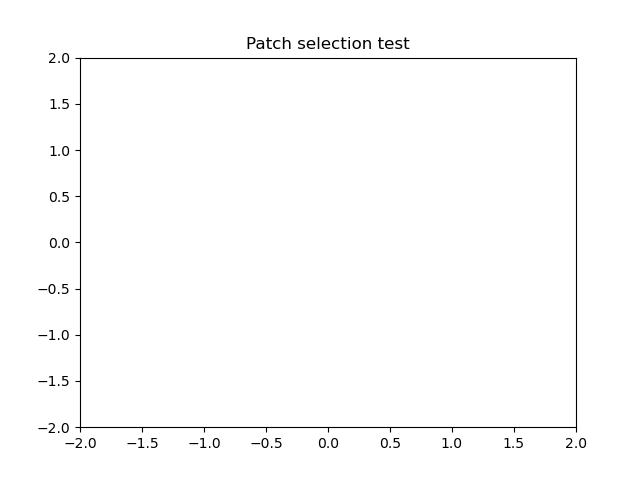

In [3]:
fig, ax = plt.subplots()
p = PolygonInteractor(ax)
ax.set_title('Patch selection test')
ax.set_xlim((-2, 2))
ax.set_ylim((-2, 2))